In [0]:
# automatically update imports
%load_ext autoreload
%autoreload 2

# snippet for relative imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [1]:
# BASE IMPORTS
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

import utils

In [2]:
dframe = utils.load_data_frame(utils.GPCI_FLAG, utils.ALL_CITIES)

In [3]:
sprawl_related_indicators = [
    # MORPHOLOGY
    'level green coverage',
    'population density',
    # ENVIRONMENT
    'water quality',
    # 'percentage renewable energy used',
    'density sulfur dioxide (so2) density nitrogen dioxide (no2)',
    'density suspended particulate matter (spm)',
    'co2 emissions',
    # PUBLIC TRANSPORT
    'punctuality coverage public transportation',
    'density railway stations',
    'commuting convenience'
    # OTHER
    # 'price level',
]
dframe_sprawl = dframe[sprawl_related_indicators]

In [4]:
# build the dataframe with averaged values for each indicator over the years
dframe_avg = DataFrame()
for col in dframe_sprawl.columns:
    dframe_avg[col] = dframe_sprawl[col].map(Series.mean)

In [5]:
# Imputing missing values
from sklearn import preprocessing
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean')
data = imp.fit_transform(dframe_avg)
dframe_imp = DataFrame(data, index=dframe_avg.index, columns=dframe_avg.columns)

/home/martibosch/.virtualenvs/urbansprawl/src/matplotlib/lib/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

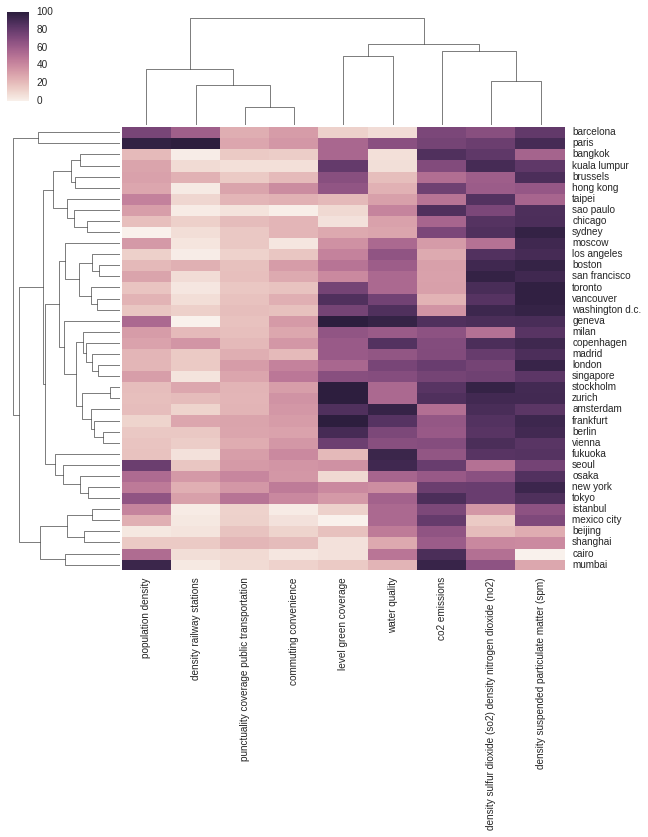

In [20]:
plt.figure()
cg = sns.clustermap(dframe_imp)
plt.setp(cg.ax_heatmap.get_yticklabels(), rotation=0)

In [40]:
def clusters_from_labels(cluster_labels, dframe, kind='rows'):
    cluster_dict = {}
    for i, label in enumerate(cluster_labels):
        if label in cluster_dict:
            if kind=='columns':
                cluster_dict[label].append(dframe.columns[i])
            else:
                cluster_dict[label].append(dframe.index[i])
        else:
            if kind=='columns':
                cluster_dict[label] = [dframe.columns[i]]
            else:
                cluster_dict[label] = [dframe.index[i]]
    return cluster_dict

In [135]:
# build flat column-clustering from the hierarchy
from scipy.cluster.hierarchy import fcluster
Z_col = cg.dendrogram_col.linkage
t_col = 3 # we want 3 clusters
cluster_labels_col = fcluster(Z_col, t_col, criterion='maxclust')
cluster_dict_col = clusters_from_labels(cluster_labels_col, dframe_imp, 'columns')
# cluster_dict

In [42]:
dframe_3d = DataFrame()
cluster_names_col = ['transport', 'environment', 'pollution'] # hardcoded

for i, cluster in enumerate(cluster_dict_col.values()):
    dframe_3d[cluster_names_col[i]] = sum(dframe_imp[indicator] for indicator in cluster) / len(cluster)

dframe_3d.head()

           transport  environment  pollution
amsterdam  22.787500      91.9625  75.566667
bangkok    13.368750      31.6000  76.029167
barcelona  48.533333      10.4500  74.833333
beijing     9.825000      33.1250  37.841667
berlin     23.287500      81.8750  80.433333

In [53]:
# build flat row-clustering from the hierarchy
from scipy.cluster.hierarchy import fcluster
Z_row = cg.dendrogram_row.linkage
t_row = 3
cluster_labels_row = fcluster(Z_row, t_row, criterion='maxclust')
cluster_dict_row = clusters_from_labels(cluster_labels_row, dframe_imp)

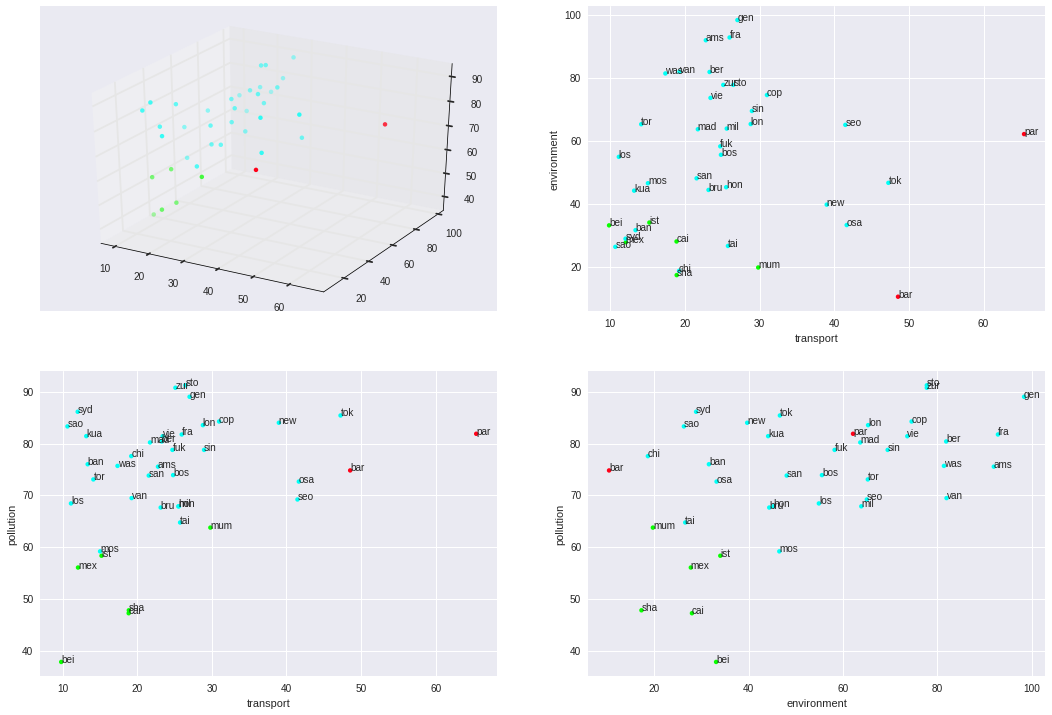

In [133]:
# plotting the clusters
import itertools
import matplotlib.cm as cm
import mpl_toolkits.mplot3d.axes3d as p3

fig = plt.figure(figsize=(18,12))
ax_11 = plt.subplot(221, projection='3d')
ax_12 = plt.subplot(222)
ax_21 = plt.subplot(223)
ax_22 = plt.subplot(224)

cmap = cm.hsv(1 / cluster_labels_row)

ax_11.scatter3D(dframe_3d.iloc[:,0], dframe_3d.iloc[:,1], dframe_3d.iloc[:,2], c=cmap)

for ax, (i,j) in zip([ax_12, ax_21, ax_22], itertools.combinations(range(3),2)):
    x = dframe_3d.iloc[:,i]
    y = dframe_3d.iloc[:,j]
    ax.scatter(x, y, c=cmap)
    ax.set_xlabel(dframe_3d.columns[i])
    ax.set_ylabel(dframe_3d.columns[j])

    for city in dframe_3d.index:
        ax.annotate(city[:3], (x[city], y[city]))                             